In [ ]:
#Set path to MAIN FOLDER OF EXPERIMENT
#cd /path/to/EXPERIMENT_FOLDER/

In [1]:
#LOAD DEPENDENCIES
import os
import time
import pickle
import logging
import numpy as np
import talos
import tensorflow as tf
import matplotlib.pyplot as plt

#IMPORT LOSS, OPTIMIZER, CALLBACK AND LAYERS
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

#IMPORT MODEL APIs
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as selected_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as student_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as teacher_preprocess

#PREVENT ERROR UNCESSARY MESSAGES
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("LIBRARIES LOADED")

LIBRARIES LOADED


In [2]:
#Tweakable parameters
MODEL_KIND = "KD_model"
MODEL_NAME = "MiniMobileNetV2"

#Models paths
PROPOSED_MODEL_PATH = "models/proposed_model/" + MODEL_NAME
HPO_PATH = "models/hpo_model/" + MODEL_NAME

#Figures paths
FIG_PATH = 'figures/' + MODEL_KIND + "/" + MODEL_NAME

#Data paths
MAIN_DATA_DIR = "ds/"
TRAIN_DATA_DIR = MAIN_DATA_DIR + "train/"
TEST_DATA_DIR = MAIN_DATA_DIR + "test/"
VALIDATION_DATA_DIR = MAIN_DATA_DIR + "val/"

print("ALL REQUERED PATHS SET")

ALL REQUERED PATHS SET


In [3]:
#Save Model Function
def save_m(model, directory, model_name):
    if not os.path.exists(directory):
        os.makedirs(directory)
    model.save(directory + "/" + model_name + ".h5")

#Save History Function
def save_h(history, directory, history_name):
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(directory + '/' + history_name + '.history', 'wb') as file:
        pickle.dump(history, file)

#Load model Function
def load_m(directory, model_name):
    if not os.path.exists(directory):
        print("Model File Does Not Exist!!")
        return 
    model = load_model(directory + "/" + model_name + ".h5")
    return model

#Load History Function
def load_h(directory, history_name):
    if not os.path.exists(directory):
        print("History File Does Not Exist!!")
        return 
    with open(directory + '/' + history_name + '.history', 'rb') as file:
        his = pickle.load(file)
    return his

def save_fig(directory, fig_name):
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory + '/' + fig_name + '.tiff', bbox_inches='tight', dpi=600, format='tiff')
    
print("ALL CUSTOM FUNCTIONS DEFIEND")

ALL CUSTOM FUNCTIONS DEFIEND


In [4]:
#DATA GENERATORS
BATCH_SIZE = 4

img_rows, img_cols = 224, 224
INPUT_SHAPE = (img_rows, img_cols,3)
MODEL_INPUT = Input(shape=INPUT_SHAPE)
print("INPUT SIZE -->", MODEL_INPUT.shape, "\n")
NUM_CLASSES = 199

def create_data_generator(pre_process=None):
    nb_train_samples = 0
    nb_val_samples = 0
    num_classes = 0
    train_generator = None
    validation_generator = None

    train_datagen = ImageDataGenerator(preprocessing_function=pre_process)
    val_datagen = ImageDataGenerator(preprocessing_function=pre_process)

    if not os.path.exists(TRAIN_DATA_DIR):
        print("TRAIN DATA DOES NOT EXITS!")
        return None, None
    else:
        print("LOAD TRAIN SAMPLES...")
        train_generator = train_datagen.flow_from_directory(
                TRAIN_DATA_DIR,
                target_size=(img_rows,img_cols),
                batch_size=BATCH_SIZE,
                class_mode='categorical',
                seed=42)
        
        #CHECK  THE NUMBER OF SAMPLES
        nb_train_samples = len(train_generator.filenames)
        if nb_train_samples == 0:
            print("NO DATA TRAIN FOUND IN TRAIN FOLDER!")
            return None, None

    print()
    if not os.path.exists(TRAIN_DATA_DIR):
        print("VALIDATION DATA DOES NOT EXITS!")
        return None, None
    else:
        print("LOAD VALIDATION SAMPLES...")
        validation_generator = val_datagen.flow_from_directory(
                VALIDATION_DATA_DIR,
                target_size=(img_rows,img_cols),
                batch_size=BATCH_SIZE,
                class_mode='categorical',
                seed=42,
                shuffle=False)

        #CHECK  THE NUMBER OF SAMPLES
        nb_validation_samples = len(validation_generator.filenames)
        if nb_validation_samples == 0:
            print("NO DATA VALIDATION FOUND IN VALIDATION FOLDER!")
            return None, None

    print()
    if nb_train_samples > 0 and nb_validation_samples > 0:
        num_classes= len(train_generator.class_indices)
        print("GENERATER ARE SET!")
        print('CLASSES TO TRAIN', num_classes, 'classes')
    
    return (train_generator, nb_train_samples), (validation_generator, nb_validation_samples)

_, _=create_data_generator()

INPUT SIZE --> (None, 224, 224, 3) 

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes


In [5]:
#Knowledge Distiller(KD)

class KDistiller(Model):
    def __init__(self, student, teacher, student_preprocess=None, teacher_preprocess=None):
        super(KDistiller, self).__init__()
        self.teacher = teacher
        self.student = student
        self.student_preprocess = student_preprocess
        self.teacher_preprocess = teacher_preprocess

    def compile(self, optimizer,  metrics, student_loss_fn, distillation_loss_fn, alpha, temperature):
        super(KDistiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # UNPACK DATA
        student_x, y = data
        teacher_x, y = data

        # PREPROCESS DATA
        if self.student_preprocess != None: student_x = self.student_preprocess(student_x)
        if self.teacher_preprocess != None: teacher_x = self.teacher_preprocess(teacher_x)
        
        # FORWARD PASS OF TEACHER
        teacher_preds = self.teacher(teacher_x, training=False)

        with tf.GradientTape() as tape:
            # FORWARD PASS OF STUDENT
            student_preds = self.student(student_x, training=True)

            # CALCULATE STUDENT LOSS
            student_loss = self.student_loss_fn(y, student_preds)

            # CALCULATE DISTISLATION LOSS
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_preds / self.temperature, axis=1),
                tf.nn.softmax(student_preds / self.temperature, axis=1),
            )

            # CALCULATE TOTAL LOSS
            total_loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # CALCULATE GRADIENT
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        # SET WEIGHTS
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # SET METRICES
        self.compiled_metrics.update_state(y, student_preds)
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, 'loss':total_loss}
        )

        return results

    def test_step(self, data):
        # UNPACK DATA
        x, y = data

        # PREPROCESS DATA
        x = self.student_preprocess(x)
        
        # GET PREDICTIONS FROM STUDENT
        y_preds = self.student(x, training=False)

        # CALCULATE STUDENT LOSS
        student_loss = self.student_loss_fn(y, y_preds)

        # SET METRICES 
        self.compiled_metrics.update_state(y, y_preds)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})

        return results

    def call(self, inputs, training):
        return self.student(inputs, training=training)

**Teacher Model :** EnsembleModel 

In [6]:
TEACHER_NAME = "MobileNetV2"
TEACHER_MODEL_PATH = "models/teacher_model/" + TEACHER_NAME

In [8]:
#PLOT THE MODEL STRUCTURE
def get_teacher():
    model = load_m(TEACHER_MODEL_PATH, TEACHER_NAME)
    model.layers[-1].activation = None
    if model != None:
        print("TEACHER MODEL LOADED SUCCESSFULLY!")

    return model

if get_teacher() != None: 
    print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
    get_teacher().summary()

TEACHER MODEL LOADED SUCCESSFULLY!
PLEASE CHECK THE ENTIRE MODEL UP TO THE END
TEACHER MODEL LOADED SUCCESSFULLY!
Model: "benchmark-onelayeroff-0_0001-MobileNetV2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 

In [9]:
#Sanity Checker
#Re-Create Data Generator
_, (validation_generator, nb_validation_samples)  = create_data_generator(pre_process=teacher_preprocess)

get_teacher().evaluate(validation_generator)

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
TEACHER MODEL LOADED SUCCESSFULLY!
299/299 [==============================] - 15s 37ms/step - loss: 14.2472 - accuracy: 0.8568


[14.247171401977539, 0.856783926486969]

**Student Model :** Mini-MNV2

In [10]:
#TRANSFER LEARNING
def get_student(model_input):
    model = load_m(PROPOSED_MODEL_PATH, MODEL_NAME)
    model.layers[-1].activation = None
    if model != None:
        print("STUDENT MODEL SUCESSFULLY BUILT!")
    return model

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
get_student(MODEL_INPUT).summary()

PLEASE CHECK THE ENTIRE MODEL UP TO THE END
STUDENT MODEL SUCESSFULLY BUILT!
Model: "ablation_final-PROPOSEDMiniMobileNetV2-39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0] 

In [11]:
#FIXED HYPERPARAMETERS
BATCH_SIZE = 4
EPOCHS = 30
DROPOUT_RATE = 0.5
OPTIMIZER = Adam

#HPO HYPERPAMETERS
TEMPERATURE = [5, 2, 10] 
ALPHA = [0.1, 0.3, 0.5]
LEARNING_RATE = [0.001, 0.01, 0.0001]
    
print("FIXED HYPERPARAMETERS")
print("---------------------")

print("BATCH_SIZE -->", BATCH_SIZE)
print("EPOCHS SET -->", EPOCHS)
print("DROPOUT_RATE -->", DROPOUT_RATE)
print("OPTIMIZER -->", OPTIMIZER.__name__,"\n")

print("HPO HYPERPARAMETERS")
print("--------------------")
print("TEMPERATURE -->", TEMPERATURE)
print("ALPHA -->", ALPHA)
print("LEARNING_RATE -->", LEARNING_RATE)

FIXED HYPERPARAMETERS
---------------------
BATCH_SIZE --> 4
EPOCHS SET --> 30
DROPOUT_RATE --> 0.5
OPTIMIZER --> Adam 

HPO HYPERPARAMETERS
--------------------
TEMPERATURE --> [5, 2, 10]
ALPHA --> [0.1, 0.3, 0.5]
LEARNING_RATE --> [0.001, 0.01, 0.0001]


**Training Student With KD**

In [12]:
dummy_x = []
dummy_y = []

# HPO PARAMETERS
p = {
    'temperature':TEMPERATURE,
    'alpha':ALPHA,
    'lr':LEARNING_RATE
    }

def distiller_model(x_train, y_train, x_val, y_val, params):
    print("\nCURRENT PARAMETERS:", params)

    #START TIMER
    import time
    start_time = time.time()
    
    #GET NEW TEACHER AND STUDENT MODEL
    teacher = get_teacher()
    student = get_student(MODEL_INPUT)

    #SET CALLBACK
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=2,
                              verbose=1, 
                              mode='max', 
                              min_lr=0.000001)

    callbacks = [reduce_lr]

    #CREATE KNOWLEDGE DISTILLER
    distiller = KDistiller(
        student=student,teacher=teacher,
        student_preprocess=student_preprocess,
        teacher_preprocess=teacher_preprocess
    )

    #COMPILE KNOWLEDGE DISTILLER
    distiller.compile(
        optimizer = OPTIMIZER(learning_rate=params['lr']),
        metrics=['accuracy'],
        student_loss_fn=CategoricalCrossentropy(from_logits=True),
        distillation_loss_fn= KLDivergence(),
        alpha=params['alpha'],
        temperature=params['temperature'],
    )

    print()
    (train_generator, nb_train_samples), (validation_generator, nb_validation_samples) = create_data_generator()

    #DISTILLING
    distiller_history = distiller.fit(train_generator,
                                        validation_data = validation_generator,
                                        steps_per_epoch = nb_train_samples // BATCH_SIZE,
                                        validation_steps = nb_validation_samples // BATCH_SIZE,
                                        epochs=EPOCHS,
                                        callbacks=callbacks, 
                                      )
    #STOP TIMER
    elapsed_time = time.time() - start_time
    train_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    print('\n\n' + train_time, 'train_time\n')
    print(elapsed_time, 'Seconds\n\n')

    print("MODEL SERIALIZING WAIT FOR A MOMENT...\n")
    save_m(distiller.student, HPO_PATH + '/HPO(t={0},a={1},l={2})'.format(params['temperature'],params['alpha'],params['lr']), MODEL_NAME)
    save_h(distiller_history.history, HPO_PATH + '/HPO(t={0},a={1},l={2})'.format(params['temperature'],params['alpha'],params['lr']), MODEL_NAME)

    return distiller_history, distiller.student

scan_object = talos.Scan(dummy_x, dummy_y,
                         x_val=dummy_x, y_val=dummy_y, 
                         model=distiller_model,
                         experiment_name='logs/',
                         params=p,
                         print_params=False,
                         save_weights=True)

  0%|                                                                                           | 0/27 [00:00<?, ?it/s]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 39s 72ms/step - accuracy: 0.0483 - student_loss: 4.8105 - distillation_loss: 0.5875 - loss: 1.0098 - val_accuracy: 0.0076 - val_student_loss: 34.8065
Epoch 2/30
497/497 [==============================] - 31s 62ms/step - accuracy: 0.1893 - student_loss: 3.4851 - distillation_loss: 0.5053 - loss: 0.8033 - val_accuracy: 0.0243 - val_student_loss: 29.1526
Epoch 3/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.3575 - student_loss: 2.5197 - distillation_loss: 0.4444 - loss: 0.6519 - val_accuracy: 0.0436 - val_student_loss: 20.9030
Epoch 4/30
497/497 [==============================] - 31s 63ms/st

  4%|██▉                                                                             | 1/27 [15:33<6:44:42, 933.94s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 33s 62ms/step - accuracy: 0.0347 - student_loss: 5.0207 - distillation_loss: 4.7438 - loss: 4.7715 - val_accuracy: 0.0352 - val_student_loss: 22.5037
Epoch 2/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.1264 - student_loss: 4.0295 - distillation_loss: 3.8754 - loss: 3.8908 - val_accuracy: 0.0419 - val_student_loss: 37.3130
Epoch 3/30
497/497 [==============================] - 31s 61ms/step - accuracy: 0.2588 - student_loss: 3.1024 - distillation_loss: 3.0571 - loss: 3.0616 - val_accuracy: 0.0755 - val_student_loss: 36.4345
Epoch 4/30
497/497 [==============================] - 31s 63ms/st

  7%|█████▉                                                                          | 2/27 [31:17<6:31:22, 939.31s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 34s 63ms/step - accuracy: 0.0383 - student_loss: 4.9184 - distillation_loss: 0.0662 - loss: 0.5514 - val_accuracy: 0.0050 - val_student_loss: 35.1280
Epoch 2/30
497/497 [==============================] - 31s 62ms/step - accuracy: 0.1601 - student_loss: 3.7528 - distillation_loss: 0.0601 - loss: 0.4293 - val_accuracy: 0.0352 - val_student_loss: 27.9925
Epoch 3/30
497/497 [==============================] - 31s 62ms/step - accuracy: 0.3273 - student_loss: 2.7336 - distillation_loss: 0.0564 - loss: 0.3241 - val_accuracy: 0.0218 - val_student_loss: 21.8908
Epoch 4/30
497/497 [==============================] - 31s 63ms/s

 11%|████████▉                                                                       | 3/27 [46:54<6:15:23, 938.48s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.01, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 36s 67ms/step - accuracy: 0.0166 - student_loss: 5.2135 - distillation_loss: 0.6069 - loss: 1.0675 - val_accuracy: 0.0050 - val_student_loss: 207.6174
Epoch 2/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.0514 - student_loss: 4.6291 - distillation_loss: 0.5664 - loss: 0.9727 - val_accuracy: 0.0050 - val_student_loss: 198.2893
Epoch 3/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.0926 - student_loss: 4.0779 - distillation_loss: 0.5358 - loss: 0.8900 - val_accuracy: 0.0050 - val_student_loss: 186.1297

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004

 15%|███████████▌                                                                  | 4/27 [1:03:06<6:04:47, 951.64s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.01, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 36s 67ms/step - accuracy: 0.0111 - student_loss: 5.5819 - distillation_loss: 5.0100 - loss: 5.0672 - val_accuracy: 0.0050 - val_student_loss: 283.5280
Epoch 2/30
497/497 [==============================] - 33s 66ms/step - accuracy: 0.0287 - student_loss: 5.2786 - distillation_loss: 4.5651 - loss: 4.6365 - val_accuracy: 0.0050 - val_student_loss: 509.6732illation_loss: 4.5675 - loss: 4.
Epoch 3/30
497/497 [==============================] - 33s 67ms/step - accuracy: 0.0634 - student_loss: 4.8916 - distillation_loss: 4.0962 - loss: 4.1758 - val_accuracy: 0.0050 - val_student_loss: 241.3105

Epoch 00003: ReduceLROnPlateau

 19%|██████████████▍                                                               | 5/27 [1:19:31<5:53:19, 963.63s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.01, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 66ms/step - accuracy: 0.0121 - student_loss: 5.2746 - distillation_loss: 0.0687 - loss: 0.5893 - val_accuracy: 0.0050 - val_student_loss: 315.1213
Epoch 2/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.0398 - student_loss: 4.7719 - distillation_loss: 0.0664 - loss: 0.5369 - val_accuracy: 0.0050 - val_student_loss: 179.1241
Epoch 3/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.0680 - student_loss: 4.3396 - distillation_loss: 0.0659 - loss: 0.4933 - val_accuracy: 0.0050 - val_student_loss: 143.8570

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00

 22%|█████████████████▎                                                            | 6/27 [1:35:13<5:34:40, 956.23s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.0001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 33s 63ms/step - accuracy: 0.0227 - student_loss: 5.2413 - distillation_loss: 0.6177 - loss: 1.0800 - val_accuracy: 0.0168 - val_student_loss: 4.5969
Epoch 2/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.0428 - student_loss: 4.8735 - distillation_loss: 0.5979 - loss: 1.0255 - val_accuracy: 0.0277 - val_student_loss: 5.1169
Epoch 3/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.0911 - student_loss: 4.4651 - distillation_loss: 0.5767 - loss: 0.9656 - val_accuracy: 0.0403 - val_student_loss: 5.2067
Epoch 4/30
497/497 [==============================] - 31s 62ms/step

 26%|████████████████████▏                                                         | 7/27 [1:50:51<5:16:45, 950.25s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.0001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 34s 63ms/step - accuracy: 0.0126 - student_loss: 5.3009 - distillation_loss: 4.9849 - loss: 5.0165 - val_accuracy: 0.0117 - val_student_loss: 5.1023
Epoch 2/30
497/497 [==============================] - 31s 62ms/step - accuracy: 0.0388 - student_loss: 4.9321 - distillation_loss: 4.7855 - loss: 4.8002 - val_accuracy: 0.0109 - val_student_loss: 5.5994
Epoch 3/30
497/497 [==============================] - 31s 62ms/step - accuracy: 0.0765 - student_loss: 4.5904 - distillation_loss: 4.5688 - loss: 4.5709 - val_accuracy: 0.0612 - val_student_loss: 2.9147
Epoch 4/30
497/497 [==============================] - 31s 62ms/step

 30%|███████████████████████                                                       | 8/27 [2:06:37<5:00:32, 949.10s/it]


CURRENT PARAMETERS: {'alpha': 0.1, 'lr': 0.0001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 33s 62ms/step - accuracy: 0.0206 - student_loss: 5.2437 - distillation_loss: 0.0688 - loss: 0.5863 - val_accuracy: 0.0143 - val_student_loss: 4.1182
Epoch 2/30
497/497 [==============================] - 31s 62ms/step - accuracy: 0.0493 - student_loss: 4.8729 - distillation_loss: 0.0665 - loss: 0.5472 - val_accuracy: 0.0411 - val_student_loss: 5.4467
Epoch 3/30
497/497 [==============================] - 31s 62ms/step - accuracy: 0.0745 - student_loss: 4.5588 - distillation_loss: 0.0648 - loss: 0.5142 - val_accuracy: 0.0394 - val_student_loss: 3.8982
Epoch 4/30
497/497 [==============================] - 31s 62ms/ste

 33%|██████████████████████████                                                    | 9/27 [2:22:06<4:42:51, 942.88s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 33s 63ms/step - accuracy: 0.0398 - student_loss: 4.9452 - distillation_loss: 0.5971 - loss: 1.9015 - val_accuracy: 0.0185 - val_student_loss: 34.0497
Epoch 2/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.1652 - student_loss: 3.6804 - distillation_loss: 0.5195 - loss: 1.4678 - val_accuracy: 0.0159 - val_student_loss: 27.4776
Epoch 3/30
497/497 [==============================] - 31s 61ms/step - accuracy: 0.3278 - student_loss: 2.7098 - distillation_loss: 0.4606 - loss: 1.1353 - val_accuracy: 0.0319 - val_student_loss: 35.5235
Epoch 4/30
497/497 [==============================] - 31s 63ms/st

 37%|████████████████████████████▌                                                | 10/27 [2:37:45<4:26:46, 941.56s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 64ms/step - accuracy: 0.0368 - student_loss: 4.9868 - distillation_loss: 4.7567 - loss: 4.8258 - val_accuracy: 0.0050 - val_student_loss: 40.6113
Epoch 2/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.1309 - student_loss: 3.8710 - distillation_loss: 3.9121 - loss: 3.8998 - val_accuracy: 0.0235 - val_student_loss: 32.5115
Epoch 3/30
497/497 [==============================] - 33s 66ms/step - accuracy: 0.2729 - student_loss: 2.9289 - distillation_loss: 3.1146 - loss: 3.0589 - val_accuracy: 0.0352 - val_student_loss: 44.0322
Epoch 4/30
497/497 [==============================] - 33s 66ms/st

 41%|███████████████████████████████▎                                             | 11/27 [2:53:50<4:12:57, 948.61s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 34s 64ms/step - accuracy: 0.0423 - student_loss: 4.9680 - distillation_loss: 0.0667 - loss: 1.5371 - val_accuracy: 0.0193 - val_student_loss: 29.2306
Epoch 2/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.1501 - student_loss: 3.8218 - distillation_loss: 0.0605 - loss: 1.1889 - val_accuracy: 0.0201 - val_student_loss: 23.9489
Epoch 3/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.3197 - student_loss: 2.7795 - distillation_loss: 0.0568 - loss: 0.8736 - val_accuracy: 0.0243 - val_student_loss: 33.3247
Epoch 4/30
497/497 [==============================] - 32s 65ms/s

 44%|██████████████████████████████████▏                                          | 12/27 [3:09:54<3:58:22, 953.48s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.01, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 65ms/step - accuracy: 0.0111 - student_loss: 5.3337 - distillation_loss: 0.6174 - loss: 2.0323 - val_accuracy: 0.0050 - val_student_loss: 278.8052
Epoch 2/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.0388 - student_loss: 4.7844 - distillation_loss: 0.5798 - loss: 1.8412 - val_accuracy: 0.0050 - val_student_loss: 132.9839
Epoch 3/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.0609 - student_loss: 4.3332 - distillation_loss: 0.5526 - loss: 1.6868 - val_accuracy: 0.0101 - val_student_loss: 91.3599
Epoch 4/30
497/497 [==============================] - 33s 66ms/s

 48%|█████████████████████████████████████                                        | 13/27 [3:25:51<3:42:40, 954.36s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.01, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 34s 64ms/step - accuracy: 0.0166 - student_loss: 5.4374 - distillation_loss: 4.9491 - loss: 5.0956 - val_accuracy: 0.0050 - val_student_loss: 234.8133
Epoch 2/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.0383 - student_loss: 5.0217 - distillation_loss: 4.5247 - loss: 4.6738 - val_accuracy: 0.0050 - val_student_loss: 147.0218
Epoch 3/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.0544 - student_loss: 4.6616 - distillation_loss: 4.1614 - loss: 4.3115 - val_accuracy: 0.0050 - val_student_loss: 148.4765

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004

 52%|███████████████████████████████████████▉                                     | 14/27 [3:41:52<3:27:13, 956.45s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.01, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 36s 67ms/step - accuracy: 0.0141 - student_loss: 5.3376 - distillation_loss: 0.0693 - loss: 1.6498 - val_accuracy: 0.0059 - val_student_loss: 69.3562
Epoch 2/30
497/497 [==============================] - 32s 65ms/step - accuracy: 0.0307 - student_loss: 4.8786 - distillation_loss: 0.0672 - loss: 1.5106 - val_accuracy: 0.0092 - val_student_loss: 140.7962
Epoch 3/30
497/497 [==============================] - 32s 65ms/step - accuracy: 0.0569 - student_loss: 4.4279 - distillation_loss: 0.0670 - loss: 1.3753 - val_accuracy: 0.0050 - val_student_loss: 98.6973
Epoch 4/30
497/497 [==============================] - 31s 62ms/s

 56%|██████████████████████████████████████████▊                                  | 15/27 [3:58:08<3:12:29, 962.49s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.0001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 66ms/step - accuracy: 0.0151 - student_loss: 5.2627 - distillation_loss: 0.6187 - loss: 2.0119 - val_accuracy: 0.0050 - val_student_loss: 6.3532
Epoch 2/30
497/497 [==============================] - 32s 65ms/step - accuracy: 0.0509 - student_loss: 4.8774 - distillation_loss: 0.5991 - loss: 1.8826 - val_accuracy: 0.0227 - val_student_loss: 4.0024
Epoch 3/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.0916 - student_loss: 4.5415 - distillation_loss: 0.5817 - loss: 1.7697 - val_accuracy: 0.0780 - val_student_loss: 4.9254
Epoch 4/30
497/497 [==============================] - 32s 64ms/step

 59%|█████████████████████████████████████████████▋                               | 16/27 [4:14:22<2:57:06, 966.00s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.0001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 66ms/step - accuracy: 0.0156 - student_loss: 5.2828 - distillation_loss: 4.9800 - loss: 5.0709 - val_accuracy: 0.0151 - val_student_loss: 5.3097
Epoch 2/30
497/497 [==============================] - 33s 66ms/step - accuracy: 0.0398 - student_loss: 4.9106 - distillation_loss: 4.7795 - loss: 4.8188 - val_accuracy: 0.0076 - val_student_loss: 5.7275
Epoch 3/30
497/497 [==============================] - 33s 66ms/step - accuracy: 0.0740 - student_loss: 4.5599 - distillation_loss: 4.5657 - loss: 4.5640 - val_accuracy: 0.0319 - val_student_loss: 5.3302
Epoch 4/30
497/497 [==============================] - 33s 67ms/step

 63%|████████████████████████████████████████████████▍                            | 17/27 [4:30:31<2:41:06, 966.67s/it]


CURRENT PARAMETERS: {'alpha': 0.3, 'lr': 0.0001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 65ms/step - accuracy: 0.0126 - student_loss: 5.2742 - distillation_loss: 0.0688 - loss: 1.6304 - val_accuracy: 0.0076 - val_student_loss: 6.1793
Epoch 2/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.0509 - student_loss: 4.9154 - distillation_loss: 0.0667 - loss: 1.5213 - val_accuracy: 0.0201 - val_student_loss: 3.3154
Epoch 3/30
497/497 [==============================] - 32s 65ms/step - accuracy: 0.0806 - student_loss: 4.5892 - distillation_loss: 0.0650 - loss: 1.4223 - val_accuracy: 0.0721 - val_student_loss: 4.1412
Epoch 4/30
497/497 [==============================] - 32s 64ms/ste

 67%|███████████████████████████████████████████████████▎                         | 18/27 [4:46:38<2:25:02, 966.91s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 66ms/step - accuracy: 0.0383 - student_loss: 4.9457 - distillation_loss: 0.5979 - loss: 2.7718 - val_accuracy: 0.0151 - val_student_loss: 14.5522
Epoch 2/30
497/497 [==============================] - 33s 65ms/step - accuracy: 0.1631 - student_loss: 3.7674 - distillation_loss: 0.5255 - loss: 2.1464 - val_accuracy: 0.0050 - val_student_loss: 38.4113
Epoch 3/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.3374 - student_loss: 2.7093 - distillation_loss: 0.4646 - loss: 1.5870 - val_accuracy: 0.0344 - val_student_loss: 22.3385
Epoch 4/30
497/497 [==============================] - 32s 64ms/st

 70%|██████████████████████████████████████████████████████▏                      | 19/27 [5:02:43<2:08:50, 966.32s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 65ms/step - accuracy: 0.0388 - student_loss: 4.9739 - distillation_loss: 4.7695 - loss: 4.8717 - val_accuracy: 0.0151 - val_student_loss: 32.7491
Epoch 2/30
497/497 [==============================] - 32s 65ms/step - accuracy: 0.1475 - student_loss: 3.8029 - distillation_loss: 3.9337 - loss: 3.8683 - val_accuracy: 0.0159 - val_student_loss: 44.1066
Epoch 3/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.2936 - student_loss: 2.8665 - distillation_loss: 3.1837 - loss: 3.0251 - val_accuracy: 0.0394 - val_student_loss: 45.2938
Epoch 4/30
497/497 [==============================] - 32s 64ms/st

 74%|█████████████████████████████████████████████████████████                    | 20/27 [5:18:44<1:52:32, 964.59s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 34s 64ms/step - accuracy: 0.0352 - student_loss: 4.9381 - distillation_loss: 0.0666 - loss: 2.5023 - val_accuracy: 0.0218 - val_student_loss: 14.6320
Epoch 2/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.1465 - student_loss: 3.7861 - distillation_loss: 0.0608 - loss: 1.9234 - val_accuracy: 0.0294 - val_student_loss: 21.1036
Epoch 3/30
497/497 [==============================] - 31s 62ms/step - accuracy: 0.3449 - student_loss: 2.7307 - distillation_loss: 0.0574 - loss: 1.3940 - val_accuracy: 0.0570 - val_student_loss: 31.7107
Epoch 4/30
497/497 [==============================] - 31s 62ms/s

 78%|███████████████████████████████████████████████████████████▉                 | 21/27 [5:34:22<1:35:39, 956.63s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.01, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 65ms/step - accuracy: 0.0101 - student_loss: 5.3623 - distillation_loss: 0.6192 - loss: 2.9908 - val_accuracy: 0.0050 - val_student_loss: 540.2321
Epoch 2/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.0272 - student_loss: 4.9363 - distillation_loss: 0.5896 - loss: 2.7630 - val_accuracy: 0.0050 - val_student_loss: 214.1087
Epoch 3/30
497/497 [==============================] - 31s 62ms/step - accuracy: 0.0559 - student_loss: 4.4616 - distillation_loss: 0.5613 - loss: 2.5114 - val_accuracy: 0.0050 - val_student_loss: 258.1146

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004

 81%|██████████████████████████████████████████████████████████████▋              | 22/27 [5:50:05<1:19:22, 952.47s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.01, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 65ms/step - accuracy: 0.0106 - student_loss: 5.4225 - distillation_loss: 4.9836 - loss: 5.2030 - val_accuracy: 0.0050 - val_student_loss: 171.4639
Epoch 2/30
497/497 [==============================] - 31s 63ms/step - accuracy: 0.0307 - student_loss: 4.9578 - distillation_loss: 4.5869 - loss: 4.7723 - val_accuracy: 0.0050 - val_student_loss: 156.0353
Epoch 3/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.0564 - student_loss: 4.5036 - distillation_loss: 4.1610 - loss: 4.3323 - val_accuracy: 0.0050 - val_student_loss: 263.3900

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004

 85%|█████████████████████████████████████████████████████████████████▌           | 23/27 [6:06:31<1:04:11, 962.77s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.01, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 65ms/step - accuracy: 0.0076 - student_loss: 5.3973 - distillation_loss: 0.0695 - loss: 2.7334 - val_accuracy: 0.0050 - val_student_loss: 315.6780
Epoch 2/30
497/497 [==============================] - 33s 66ms/step - accuracy: 0.0272 - student_loss: 4.9186 - distillation_loss: 0.0672 - loss: 2.4929 - val_accuracy: 0.0050 - val_student_loss: 240.3064
Epoch 3/30
497/497 [==============================] - 33s 66ms/step - accuracy: 0.0609 - student_loss: 4.5204 - distillation_loss: 0.0670 - loss: 2.2937 - val_accuracy: 0.0050 - val_student_loss: 251.8767

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00

 89%|██████████████████████████████████████████████████████████████████████▏        | 24/27 [6:22:48<48:20, 966.85s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.0001, 'temperature': 5}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 36s 66ms/step - accuracy: 0.0166 - student_loss: 5.2610 - distillation_loss: 0.6189 - loss: 2.9399 - val_accuracy: 0.0084 - val_student_loss: 5.4437
Epoch 2/30
497/497 [==============================] - 32s 65ms/step - accuracy: 0.0438 - student_loss: 4.9127 - distillation_loss: 0.6016 - loss: 2.7571 - val_accuracy: 0.0092 - val_student_loss: 4.3198
Epoch 3/30
497/497 [==============================] - 32s 65ms/step - accuracy: 0.0891 - student_loss: 4.5840 - distillation_loss: 0.5839 - loss: 2.5840 - val_accuracy: 0.0134 - val_student_loss: 6.3613
Epoch 4/30
497/497 [==============================] - 33s 65ms/step

 93%|█████████████████████████████████████████████████████████████████████████▏     | 25/27 [6:39:06<32:20, 970.17s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.0001, 'temperature': 2}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 36s 66ms/step - accuracy: 0.0121 - student_loss: 5.2864 - distillation_loss: 4.9801 - loss: 5.1333 - val_accuracy: 0.0109 - val_student_loss: 5.8317
Epoch 2/30
497/497 [==============================] - 33s 66ms/step - accuracy: 0.0483 - student_loss: 4.9030 - distillation_loss: 4.7804 - loss: 4.8417 - val_accuracy: 0.0059 - val_student_loss: 5.5791
Epoch 3/30
497/497 [==============================] - 33s 67ms/step - accuracy: 0.0816 - student_loss: 4.5840 - distillation_loss: 4.5921 - loss: 4.5881 - val_accuracy: 0.0268 - val_student_loss: 5.5427
Epoch 4/30
497/497 [==============================] - 33s 67ms/step

 96%|████████████████████████████████████████████████████████████████████████████   | 26/27 [6:55:20<16:11, 971.51s/it]


CURRENT PARAMETERS: {'alpha': 0.5, 'lr': 0.0001, 'temperature': 10}
TEACHER MODEL LOADED SUCCESSFULLY!
STUDENT MODEL SUCESSFULLY BUILT!

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes
Epoch 1/30
497/497 [==============================] - 35s 65ms/step - accuracy: 0.0141 - student_loss: 5.2666 - distillation_loss: 0.0688 - loss: 2.6677 - val_accuracy: 0.0084 - val_student_loss: 5.5864
Epoch 2/30
497/497 [==============================] - 32s 63ms/step - accuracy: 0.0559 - student_loss: 4.8943 - distillation_loss: 0.0667 - loss: 2.4805 - val_accuracy: 0.0151 - val_student_loss: 3.7111
Epoch 3/30
497/497 [==============================] - 32s 64ms/step - accuracy: 0.0937 - student_loss: 4.5659 - distillation_loss: 0.0650 - loss: 2.3155 - val_accuracy: 0.0218 - val_student_loss: 4.7057
Epoch 4/30
497/497 [==============================] - 32s 64ms/ste

100%|███████████████████████████████████████████████████████████████████████████████| 27/27 [7:11:22<00:00, 958.61s/it]


**Select Best Student**

In [13]:
#Re-Create Data Generator
_, (validation_generator, nb_validation_samples)  = create_data_generator(pre_process=student_preprocess)

LOAD TRAIN SAMPLES...
Found 1990 images belonging to 199 classes.

LOAD VALIDATION SAMPLES...
Found 1194 images belonging to 199 classes.

GENERATER ARE SET!
CLASSES TO TRAIN 199 classes


In [14]:
#Select the model with highest validation accuracy
def ChooseBest():
    best_model = 0
    best_temp = 0
    best_alpha = 0
    best_lr = 0
    max_val_acc = 0

    for a in ALPHA:
        for t in TEMPERATURE:
          for l in LEARNING_RATE:
              print("\nFor Temperature = {0} & alpha= {1} & lr={2}".format(t,a,l))
              #load trained model with temp t and alpha a
              model_path = HPO_PATH + '/HPO(t={0},a={1},l={2})'.format(t,a,l)
              student_model = load_m(model_path, MODEL_NAME)
              student_model.compile(metrics=['accuracy'], loss=CategoricalCrossentropy(from_logits=True))
              #validate model
              val_acc = student_model.evaluate(validation_generator)[1]

              #update best parameters
              if val_acc > max_val_acc:
                  max_val_acc = val_acc
                  best_model = student_model
                  best_alpha = a
                  best_temp = t
                  best_lr = l
                
    return best_alpha, best_temp, best_lr, best_model

best_alpha, best_temp, best_lr, best_model = ChooseBest()

print('\nBest Temperature:', best_temp)
print('Best Alpha:', best_alpha)
print('Best Learning Rate:', best_lr)


For Temperature = 5 & alpha= 0.1 & lr=0.001
299/299 [==============================] - 8s 26ms/step - loss: 0.3527 - accuracy: 0.9012

For Temperature = 5 & alpha= 0.1 & lr=0.01
299/299 [==============================] - 8s 26ms/step - loss: 0.9212 - accuracy: 0.7487

For Temperature = 5 & alpha= 0.1 & lr=0.0001
299/299 [==============================] - 8s 26ms/step - loss: 1.3825 - accuracy: 0.6750

For Temperature = 2 & alpha= 0.1 & lr=0.001
299/299 [==============================] - 8s 26ms/step - loss: 0.5972 - accuracy: 0.8752

For Temperature = 2 & alpha= 0.1 & lr=0.01
299/299 [==============================] - 8s 26ms/step - loss: 1.5139 - accuracy: 0.7219

For Temperature = 2 & alpha= 0.1 & lr=0.0001
299/299 [==============================] - 8s 26ms/step - loss: 1.1839 - accuracy: 0.6960

For Temperature = 10 & alpha= 0.1 & lr=0.001
299/299 [==============================] - 9s 26ms/step - loss: 0.3738 - accuracy: 0.8970

For Temperature = 10 & alpha= 0.1 & lr=0.01
299/299 [

**Evaluating best student model on Validation and Test**

In [15]:
#LOAD TEST DATA
test_datagen = ImageDataGenerator(preprocessing_function=student_preprocess)

if not os.path.exists(TEST_DATA_DIR):
    print("TEST DATA DOES NOT EXITS!")
else:
    print("LOAD TEST SAMPLES...")
    test_generator = test_datagen.flow_from_directory(
                TEST_DATA_DIR,
                target_size=(img_rows,img_cols),
                batch_size=BATCH_SIZE,
                class_mode='categorical',
                seed=42,
                shuffle=False)

    #CHECK  THE NUMBER OF SAMPLES
    nb_test_samples = len(test_generator.filenames)
    if nb_test_samples == 0:
        print("NO DATA TEST FOUND IN TEST FOLDER!")

LOAD TEST SAMPLES...
Found 796 images belonging to 199 classes.


In [16]:
#Evaluate Best Student model against Teacher model on test set
print("Evaluating Best Student on validation dataset")
best_model.evaluate(validation_generator)

print("\nEvaluating Best Student on test dataset")
best_model.evaluate(test_generator)

Evaluating Best Student on validation dataset
299/299 [==============================] - 8s 26ms/step - loss: 0.3527 - accuracy: 0.9012

Evaluating Best Student on test dataset
199/199 [==============================] - 8s 42ms/step - loss: 0.3152 - accuracy: 0.8932


[0.31524577736854553, 0.893216073513031]

**Saving Model**

In [17]:
import shutil

des = PROPOSED_MODEL_PATH + '-KD'

#save models
shutil.copytree(HPO_PATH + '/HPO(t={0},a={1},l={2})'.format(best_temp,best_alpha,best_lr), des)

print("[INFO] BEST STUDENT MODEL AND HISTORY SAVED")

[INFO] BEST STUDENT MODEL AND HISTORY SAVED


In [18]:
#Figure
dpi = 1000
plt.rcParams.update({'figure.dpi': dpi})
figsize = (12, 12)

history = load_h(PROPOSED_MODEL_PATH + '-KD', MODEL_NAME)

#Markers
marker_train_accuracy = 's'
marker_validation_accuracy = 'x'
marker_train_loss = 'o'
marker_validation_loss = '|'
marker_fillstyle_train = 'none'
marker_fillstyle_validation = 'none'
marker_plot_markersize = 25
marker_plot_markerwidth = 3

#Lines
line_style_train = '-' 
line_style_validation = '--'
line_width_train = '5'
line_width_val = line_width_train
line_color_train_accuracy = 'black'
line_color_val_accuracy = 'black'
line_color_train_loss = 'black'
line_color_val_loss = 'black'

#Labels
train_accuracy_label = 'Train ' + 'Acc'
validation_accuracy_label = 'Val ' + 'Acc'
train_loss_label = 'Train ' + 'Loss'
validation_loss_label = 'Val ' 'Loss'
x_label_font_size = 56
y_label_font_size = x_label_font_size
x_label_font = 'Tahoma'
y_label_font = x_label_font
# x_label_fontweight = 'bold'
# y_label_fontweight = x_label_fontweight

#Ticks
spine_axis_thickness = 4
tick_font_size = 42
tick_length = 12
tick_width = spine_axis_thickness

#Legend
legend_border_pad = 0.35
legend_line_width = 5
legend_font_size = 50
legend_edge_color = 'black'
legend_label_spacing = 0.5
legend_location = 'best'
legend_ncol = 1
legend_font = 'Tahoma'
legend_has_frame = True

<Figure size 7200x7200 with 0 Axes>

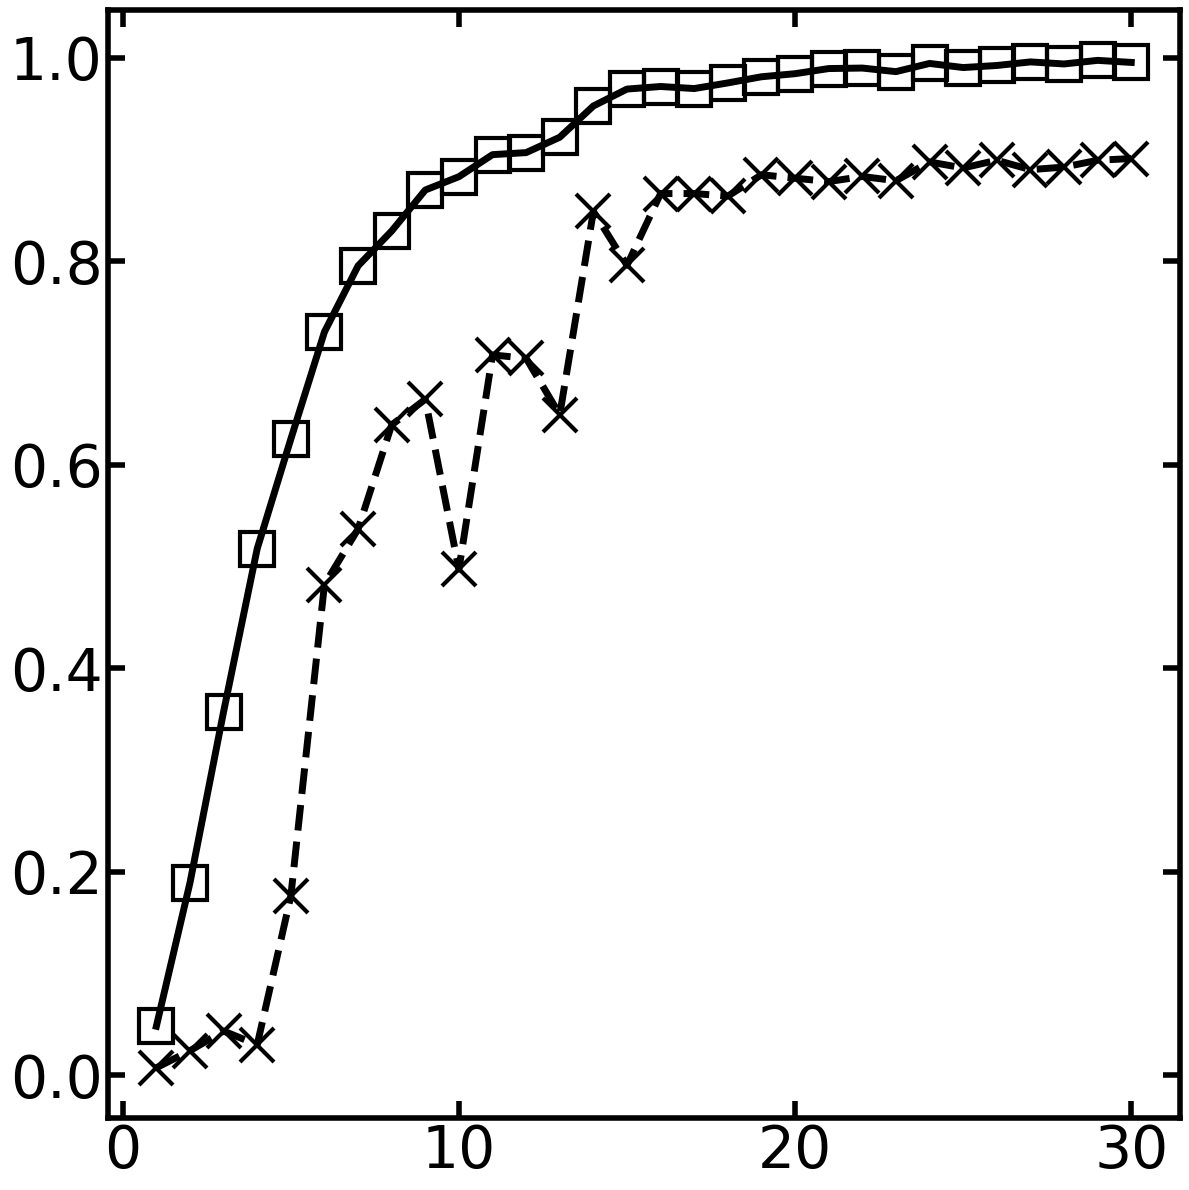

In [19]:
#Accuracy and Loss Graph
epochs = EPOCHS

plt.style.use("default")
plt.figure(figsize = figsize, 
           dpi = 600, 
           edgecolor = 'black', 
           facecolor = 'white', 
           linewidth = 0)
plt.tight_layout()
plt.rc('xtick', labelsize = tick_font_size, direction="in") 
plt.rc('ytick', labelsize = tick_font_size, direction="in") 

fig, ax = plt.subplots(figsize = figsize)
plt.gcf().subplots_adjust(bottom = 0.15)
plt.setp(ax.spines.values(), linewidth = spine_axis_thickness)

plt.tick_params(length = tick_length, 
                width = tick_width, 
                right = True, 
                top = True)

plt.plot(np.arange(1, epochs + 1), 
         history["accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_accuracy, 
         lw = line_width_train, 
         marker = marker_train_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, 
         label = train_accuracy_label)

plt.plot(np.arange(1, epochs + 1), 
         history["val_accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_accuracy, 
         lw = line_width_val, 
         marker = marker_validation_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_accuracy_label)

plt.tight_layout()
save_fig(FIG_PATH, MODEL_NAME + '-AccuracyGraph')

<Figure size 7200x7200 with 0 Axes>

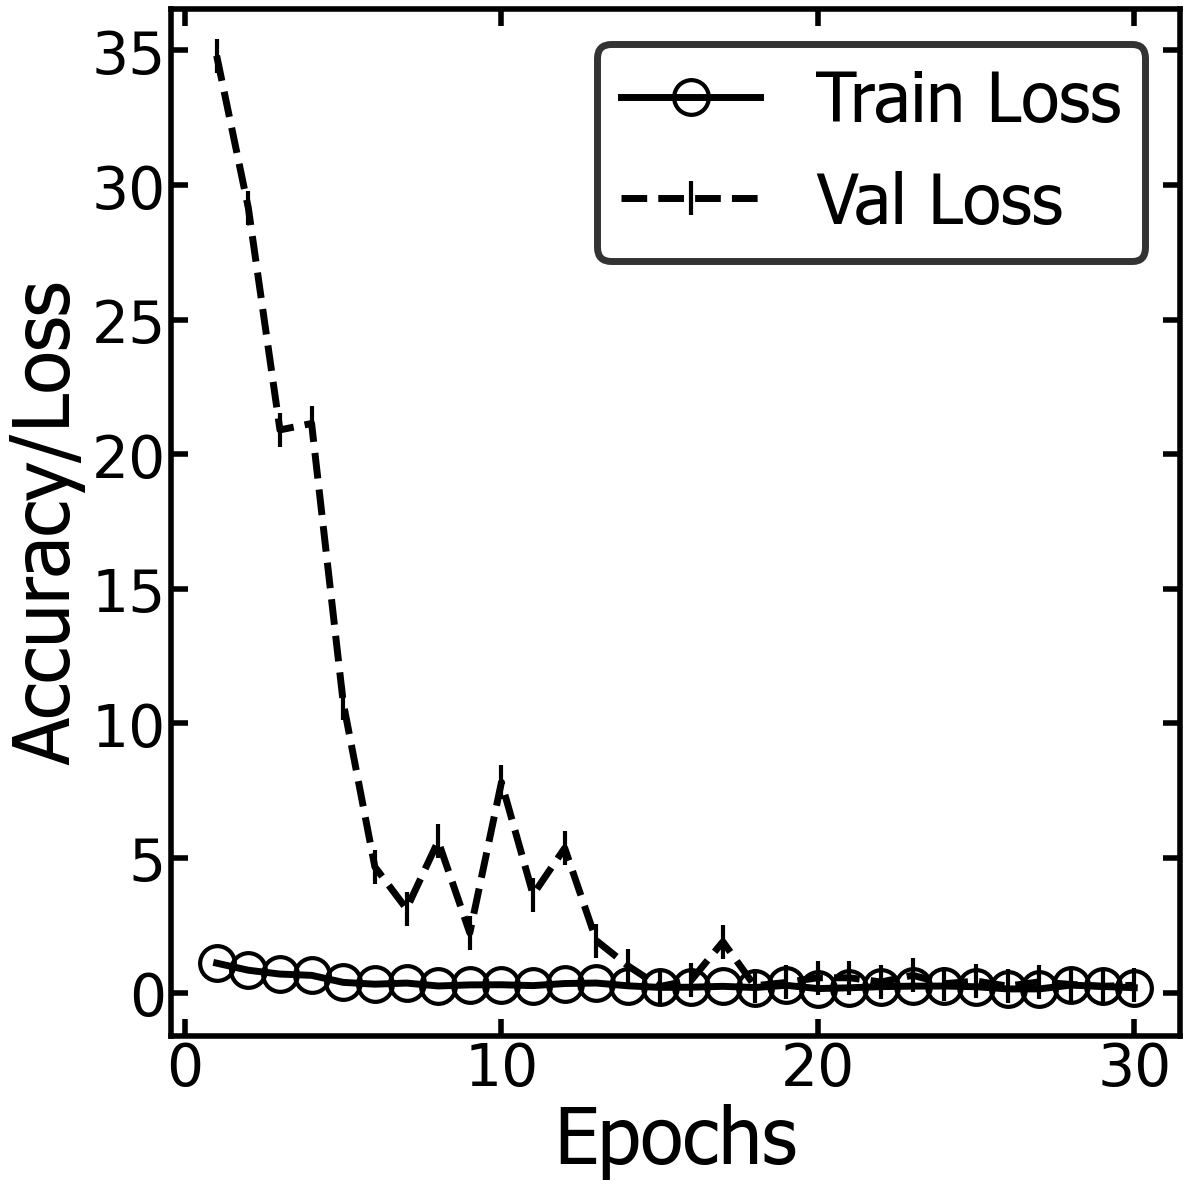

In [20]:
#Accuracy and Loss Graph
epochs = EPOCHS

plt.style.use("default")
plt.figure(figsize = figsize, 
           dpi = 600, 
           edgecolor = 'black', 
           facecolor = 'white', 
           linewidth = 0)
plt.tight_layout()
plt.rc('xtick', labelsize = tick_font_size, direction="in") 
plt.rc('ytick', labelsize = tick_font_size, direction="in") 

fig, ax = plt.subplots(figsize = figsize)
plt.gcf().subplots_adjust(bottom = 0.15)
plt.setp(ax.spines.values(), linewidth = spine_axis_thickness)

plt.tick_params(length = tick_length, 
                width = tick_width, 
                right = True, 
                top = True)

plt.plot(np.arange(1, epochs + 1), 
         history["loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_loss, 
         lw = line_width_train, 
         marker = marker_train_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, label = train_loss_label)

plt.plot(np.arange(1, epochs + 1), 
         history["val_student_loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_loss, 
         lw = line_width_val, 
         marker = marker_validation_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_loss_label)

plt.xlabel("Epochs", fontfamily = x_label_font, fontsize = x_label_font_size, color ='black')
plt.ylabel("Accuracy/Loss", fontfamily = y_label_font, fontsize = y_label_font_size, color = 'black')

legend = plt.legend(loc = legend_location, 
                    ncol = legend_ncol, 
                    frameon = legend_has_frame, 
                    fontsize=legend_font_size, 
                    edgecolor=legend_edge_color, 
                    borderpad=legend_border_pad, 
                    labelspacing=legend_label_spacing)

frame = legend.get_frame()
legend.get_frame().set_linewidth(legend_line_width)
legend.get_frame().set_edgecolor(legend_edge_color)
plt.setp(legend.texts, family = legend_font)

plt.tight_layout()
save_fig(FIG_PATH, MODEL_NAME + '-LossGraph')